In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses
from keras_spectral_norm_layers import DenseSN, ConvSN1D, ConvSN2D, ConvSN3D, EmbeddingSN

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

import os
import subprocess

from keras.layers import BatchNormalization


Using TensorFlow backend.


In [2]:
from keras.layers import Layer, InputSpec
from keras import initializers, regularizers, constraints

class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class NonParametricBatchNormalization(Layer):
    """Batch normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(NonParametricBatchNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(NonParametricBatchNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [26]:

def get_make_gen_resblock_func(norm_layer_type='batch_normalization', norm_static_mode=True) :

    def make_gen_resblock(n_channels=64, window_size=3, stride=1, dilation=1, group_ix=0, layer_ix=0) :

        #Initialize res block layers
        batch_norm_0 = None
        if norm_layer_type == 'batch_normalization' :
            batch_norm_0 = BatchNormalization(axis=-1, name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')
        elif norm_layer_type == 'non_parametric_batch_normalization' :
            batch_norm_0 = NonParametricBatchNormalization(axis=-1, name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')
        
        relu_0 = Lambda(lambda x: K.relu(x))

        deconv_0 = Conv2DTranspose(n_channels, (1, window_size), strides=(1, stride), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_deconv_0')

        batch_norm_1 = None
        if norm_layer_type == 'batch_normalization' :
            batch_norm_1 = BatchNormalization(axis=-1, name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')
        elif norm_layer_type == 'non_parametric_batch_normalization' :
            batch_norm_1 = NonParametricBatchNormalization(axis=-1, name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')
        
        relu_1 = Lambda(lambda x: K.relu(x))

        conv_1 = Conv2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

        skip_deconv_0 = Conv2DTranspose(n_channels, (1, 1), strides=(1, stride), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_deconv_0')

        skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_generator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

        #Execute res block
        def _resblock_func(input_tensor, training=True) :

            if norm_static_mode :
                batch_norm_0_out = batch_norm_0(input_tensor, training=training)
                relu_0_out = relu_0(batch_norm_0_out)
                deconv_0_out = deconv_0(relu_0_out)

                batch_norm_1_out = batch_norm_1(deconv_0_out, training=training)
                relu_1_out = relu_1(batch_norm_1_out)
                conv_1_out = conv_1(relu_1_out)
            else :
                batch_norm_0_out = batch_norm_0(input_tensor)
                relu_0_out = relu_0(batch_norm_0_out)
                deconv_0_out = deconv_0(relu_0_out)

                batch_norm_1_out = batch_norm_1(deconv_0_out)
                relu_1_out = relu_1(batch_norm_1_out)
                conv_1_out = conv_1(relu_1_out)

            skip_deconv_0_out = skip_deconv_0(input_tensor)

            skip_1_out = skip_1([conv_1_out, skip_deconv_0_out])

            return skip_1_out

        return _resblock_func
    
    return make_gen_resblock

#GAN Generator Model definition
def load_generator_resnet(batch_size, seq_length=256, make_gen_resblock=None) :

    #Generator network parameters
    latent_size = 100
    n_out_channels = 4
    window_size = 3

    strides = [2, 2, 2, 2, 2, 1]
    dilations = [1, 1, 1, 1, 1, 1]
    channels = [384, 256, 128, 64, 32, 32]
    initial_length = 8
    n_resblocks = len(strides)

    #Policy network definition
    policy_dense_0 = Dense(initial_length * channels[0], activation='linear', kernel_initializer='glorot_normal', name='policy_generator_dense_0')
    policy_dense_0_reshape = Reshape((1, initial_length, channels[0]))

    curr_length = initial_length

    class_concats = []
    resblocks = []
    for layer_ix in range(n_resblocks) :
        resblocks.append(make_gen_resblock(n_channels=channels[layer_ix], window_size=window_size, stride=strides[layer_ix], dilation=dilations[layer_ix], group_ix=0, layer_ix=layer_ix))

    #final_batch_norm = BatchNormalization(name='policy_generator_final_batch_norm')
    #final_relu = Lambda(lambda x: K.relu(x))
    final_conv = Conv2D(n_out_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_generator_final_conv')

    def _generator_func(seed_input, training=True) :

        policy_dense_0_out = policy_dense_0_reshape(policy_dense_0(seed_input))

        #Connect group of res blocks
        output_tensor = policy_dense_0_out

        #Res block group 0
        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks[layer_ix](output_tensor, training=training)

        #Final conv out
        #final_batch_norm_out = final_batch_norm(output_tensor, training=training)
        #final_relu_out = final_relu(final_batch_norm_out)
        final_conv_out = final_conv(output_tensor)#final_conv(final_relu_out)

        return final_conv_out

    return _generator_func


In [27]:

def make_disc_resblock_pooled(n_channels=64, window_size=3, dilation=1, drop_rate=0.0, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.3))

    conv_0 = ConvSN2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_snconv_0')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.3))

    conv_1 = ConvSN2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_snconv_1')
    
    pool_1 = AveragePooling2D(pool_size=(1, 2))
    
    drop_1 = Dropout(drop_rate, name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_drop_1')
    
    skip_conv_0 = ConvSN2D(n_channels, (1, 1), dilation_rate=(1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_snconv_0')
    
    skip_pool_0 = AveragePooling2D(pool_size=(1, 2))

    skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')
    
    #Execute res block
    def _resblock_func(input_tensor) :
        
        relu_0_out = relu_0(input_tensor)
        conv_0_out = conv_0(relu_0_out)

        relu_1_out = relu_1(conv_0_out)
        conv_1_out = conv_1(relu_1_out)
        pool_1_out = pool_1(conv_1_out)
        if drop_rate > 0.0 :
            pool_1_out = drop_1(pool_1_out, training=True)
        
        skip_conv_0_out = skip_conv_0(input_tensor)
        skip_pool_0_out = skip_pool_0(skip_conv_0_out)

        skip_1_out = skip_1([pool_1_out, skip_pool_0_out])
        
        return skip_1_out

    return _resblock_func

def make_disc_resblock(n_channels=64, window_size=3, dilation=1, drop_rate=0.0, group_ix=0, layer_ix=0) :

    #Initialize res block layers
    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.3))

    conv_0 = ConvSN2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_snconv_0')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.3))

    conv_1 = ConvSN2D(n_channels, (1, window_size), dilation_rate=(1, dilation), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_snconv_1')
    
    drop_1 = Dropout(drop_rate, name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_drop_1')
    
    skip_conv_0 = ConvSN2D(n_channels, (1, 1), dilation_rate=(1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_snconv_0')
    
    skip_1 = Lambda(lambda x: x[0] + x[1], name='policy_discriminator_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')
    
    #Execute res block
    def _resblock_func(input_tensor) :
        
        relu_0_out = relu_0(input_tensor)
        conv_0_out = conv_0(relu_0_out)

        relu_1_out = relu_1(conv_0_out)
        conv_1_out = conv_1(relu_1_out)
        if drop_rate > 0.0 :
            conv_1_out = drop_1(conv_1_out, training=True)
        
        skip_conv_0_out = skip_conv_0(input_tensor)

        skip_1_out = skip_1([conv_1_out, skip_conv_0_out])
        
        return skip_1_out

    return _resblock_func

def minibatch_stddev_layer(x, group_size=4) :
    group_size = tf.minimum(group_size, tf.shape(x)[0])  # Minibatch must be divisible by (or smaller than) group_size.
    s = x.shape  # [NCHW]  Input shape.
    y = tf.reshape(x, [group_size, -1, s[1], s[2], s[3]])  # [GMHWC] Split minibatch into M groups of size G.
    y = tf.cast(y, tf.float32)  # [GMHWC] Cast to FP32.
    y -= tf.reduce_mean(y, axis=0, keepdims=True)  # [GMCHW] Subtract mean over group.
    y = tf.reduce_mean(tf.square(y), axis=0)  # [MCHW]  Calc variance over group.
    y = tf.sqrt(y + 1e-8)  # [MCHW]  Calc stddev over group.
    
    y = tf.reduce_mean(y, axis=3, keepdims=True)  # [M111]  Take average over fmaps.
    y = tf.cast(y, x.dtype)  # [M111]  Cast back to original data type.
    y = tf.tile(y, [group_size, 1, 1, 1])  # [NHW1]  Replicate over group.

    return tf.concat([x, y], axis=3)  # [NHWC]  Append as new fmap.

#GAN Discriminator Model definition
def load_discriminator_resnet(batch_size, seq_length=256) :

    downsamples = [False, True, True, True]
    dilations = [1, 1, 1, 1]
    channels = [32, 64, 128, 256]
    window_sizes = [7, 7, 3, 3]
    drop_outs = [0.0, 0.0, 0.0, 0.0]
    
    n_resblocks = len(dilations)

    #policy_conv_0 = Conv2D(channels[0], (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_conv_0')
    
    resblocks = []
    for layer_ix in range(n_resblocks) :
        if downsamples[layer_ix] :
            resblocks.append(make_disc_resblock_pooled(n_channels=channels[layer_ix], window_size=window_sizes[layer_ix], dilation=dilations[layer_ix], drop_rate=drop_outs[layer_ix], group_ix=0, layer_ix=layer_ix))
        else :
            resblocks.append(make_disc_resblock(n_channels=channels[layer_ix], window_size=window_sizes[layer_ix], dilation=dilations[layer_ix], drop_rate=drop_outs[layer_ix], group_ix=0, layer_ix=layer_ix))
    
    #last_block_relu = Lambda(lambda x: K.relu(x, alpha=0.3))
    last_block_stdev = Lambda(lambda x: minibatch_stddev_layer(x, group_size=4))
    last_block_conv = ConvSN2D(channels[-1], (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='policy_discriminator_last_block_conv')
    
    real_flatten = Flatten()
    real_score = DenseSN(1, activation='linear', name='policy_discriminator_real_score')
    
    def _discriminator_func(seq_input) :
        
        #policy_conv_0_out = policy_conv_0(seq_input)
        
        #Connect group of res blocks
        output_tensor = seq_input#policy_conv_0_out

        #Res block group 0
        for layer_ix in range(n_resblocks) :
            output_tensor = resblocks[layer_ix](output_tensor)

        #Append Stdev features
        output_tensor = last_block_stdev(output_tensor)
        
        #Last res block extr conv
        output_tensor = last_block_conv(output_tensor)
        
        #Final dense out
        real_score_out = real_score(real_flatten(output_tensor))

        return real_score_out

    return _discriminator_func


In [7]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/beyond-binary-ternary-and-one-hot-neurons.html
#See Github https://github.com/spitis/

def st_sampled_softmax(logits):
    with ops.name_scope("STSampledSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.squeeze(tf.multinomial(logits, 1), 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

def st_hardmax_softmax(logits):
    with ops.name_scope("STHardmaxSoftmax") as namescope :
        nt_probs = tf.nn.softmax(logits)
        onehot_dim = logits.get_shape().as_list()[1]
        sampled_onehot = tf.one_hot(tf.argmax(nt_probs, 1), onehot_dim, 1.0, 0.0)
        with tf.get_default_graph().gradient_override_map({'Ceil': 'Identity', 'Mul': 'STMul'}):
            return tf.ceil(sampled_onehot * nt_probs)

@ops.RegisterGradient("STMul")
def st_mul(op, grad):
    return [grad, grad]


In [28]:

#PWM Masking and Sampling helper functions

def mask_pwm(inputs) :
    pwm, onehot_template, onehot_mask = inputs

    return pwm * onehot_mask + onehot_template

def sample_pwm_only(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = st_sampled_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))

def sample_pwm(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = sampled_pwm = K.switch(K.learning_phase(), st_sampled_softmax(flat_pwm), st_hardmax_softmax(flat_pwm))

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))

def max_pwm(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    seq_length = K.shape(pwm_logits)[2]
    n_channels = K.shape(pwm_logits)[3]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * seq_length, n_channels))
    sampled_pwm = sampled_pwm = st_hardmax_softmax(flat_pwm)

    return K.reshape(sampled_pwm, (n_sequences, 1, seq_length, n_channels))


#Generator helper functions
def initialize_sequence_templates(generator, sequence_templates) :

    embedding_templates = []
    embedding_masks = []

    for k in range(len(sequence_templates)) :
        sequence_template = sequence_templates[k]
        onehot_template = iso.OneHotEncoder(seq_length=len(sequence_template))(sequence_template).reshape((1, len(sequence_template), 4))

        for j in range(len(sequence_template)) :
            if sequence_template[j] not in ['N', 'X'] :
                nt_ix = np.argmax(onehot_template[0, j, :])
                onehot_template[:, j, :] = -4.0
                onehot_template[:, j, nt_ix] = 10.0
            elif sequence_template[j] == 'X' :
                onehot_template[:, j, :] = -1.0

        onehot_mask = np.zeros((1, len(sequence_template), 4))
        for j in range(len(sequence_template)) :
            if sequence_template[j] == 'N' :
                onehot_mask[:, j, :] = 1.0

        embedding_templates.append(onehot_template.reshape(1, -1))
        embedding_masks.append(onehot_mask.reshape(1, -1))

    embedding_templates = np.concatenate(embedding_templates, axis=0)
    embedding_masks = np.concatenate(embedding_masks, axis=0)

    generator.get_layer('template_dense').set_weights([embedding_templates])
    generator.get_layer('template_dense').trainable = False

    generator.get_layer('mask_dense').set_weights([embedding_masks])
    generator.get_layer('mask_dense').trainable = False


#Generator construction function
def build_sampler(batch_size, seq_length, n_classes=1, n_samples=None, validation_sample_mode='max') :

    use_samples = True
    if n_samples is None :
        use_samples = False
        n_samples = 1

    
    #Initialize Reshape layer
    reshape_layer = Reshape((1, seq_length, 4))

    #Initialize template and mask matrices
    onehot_template_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='zeros', name='template_dense')
    onehot_mask_dense = Embedding(n_classes, seq_length * 4, embeddings_initializer='ones', name='mask_dense')

    #Initialize Templating and Masking Lambda layer
    masking_layer = Lambda(mask_pwm, output_shape = (1, seq_length, 4), name='masking_layer')
    
    #Initialize PWM normalization layer
    pwm_layer = Softmax(axis=-1, name='pwm')
    
    #Initialize sampling layers
    sample_func = sample_pwm
    if validation_sample_mode == 'sample' :
        sample_func = sample_pwm_only
    
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_func, name='pwm_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, 1, seq_length, 4)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        onehot_template = reshape_layer(onehot_template_dense(class_input))
        onehot_mask = reshape_layer(onehot_mask_dense(class_input))
        
        #Add Template and Multiply Mask
        pwm_logits = masking_layer([raw_logits, onehot_template, onehot_mask])
        
        #Compute PWM (Nucleotide-wise Softmax)
        pwm = pwm_layer(pwm_logits)
        
        sampled_pwm = None
        
        #Optionally tile each PWM to sample from and create sample axis
        if use_samples :
            pwm_logits_upsampled = upsampling_layer(pwm_logits)
            sampled_pwm = sampling_layer(pwm_logits_upsampled)
            sampled_pwm = permute_layer(sampled_pwm)
        else :
            sampled_pwm = sampling_layer(pwm_logits)
        
        
        return pwm_logits, pwm, sampled_pwm
    
    return _sampler_func


def build_sample_axis_flattener(batch_size, predictor_func, n_samples=None) :

    input_deflate_layer, output_inflate_layer = None, None
    if n_samples is not None :
        input_deflate_layer = Lambda(lambda x: K.reshape(x, (K.shape(x)[0] * K.shape(x)[1], K.shape(x)[2], K.shape(x)[3], K.shape(x)[4])))
        output_inflate_layer = Lambda(lambda x: K.reshape(x, (batch_size, n_samples, K.shape(x)[-1])))
    
    def _deflate_inflate_func(sequence_input) :
        if n_samples is None :
            return predictor_func(sequence_input)
        else :
            return output_inflate_layer(predictor_func(input_deflate_layer(sequence_input)))

    return _deflate_inflate_func


In [59]:
#Simple Library

sequence_templates = [
    'ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCGCCTAACCCTAAGCAGATTCTTCATGCA'
]


In [60]:
#Initialize Generator and Discriminator networks
batch_size = 32

seq_length = 256
n_channels = 4
n_samples = 10

#Load Generator
make_gen_resblock = get_make_gen_resblock_func(norm_layer_type='non_parametric_batch_normalization', norm_static_mode=True)
generator = load_generator_resnet(batch_size, seq_length=seq_length, make_gen_resblock=make_gen_resblock)

#Load Sampler
sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=n_samples, validation_sample_mode='sample')

#Load Discriminator
discriminator = load_discriminator_resnet(batch_size, seq_length=seq_length)

discriminator_for_fake_data = build_sample_axis_flattener(batch_size, discriminator, n_samples=n_samples)
discriminator_for_real_data = build_sample_axis_flattener(batch_size, discriminator, n_samples=1)

#Compile Validation Generator and Discriminator Keras Models

#Compile Validation Generator
valid_generator_class = Input(batch_shape=(batch_size, 1))
valid_generator_input = Input(batch_shape=(batch_size, 100))

valid_sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=None, validation_sample_mode='max')
valid_logits, valid_pwm, valid_sample = valid_sampler(valid_generator_class, generator(valid_generator_input, training=True))

generator_model = Model(
    inputs=[
        valid_generator_class,
        valid_generator_input
    ],
    outputs=[
        valid_logits,
        valid_pwm,
        valid_sample
    ]
)

#Compile model
generator_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=[lambda true, pred: pred, lambda true, pred: pred, lambda true, pred: pred]
)

#Compile Validation Discriminator
valid_data = Input(batch_shape=(batch_size, 1, seq_length, n_channels))

discriminator_for_valid_data = build_sample_axis_flattener(batch_size, discriminator, n_samples=None)
valid_discriminator_score = discriminator_for_valid_data(valid_data)

discriminator_model = Model(
    inputs=[
        valid_data
    ],
    outputs=[
        valid_discriminator_score
    ]
)

#Compile model
discriminator_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss=lambda true, pred: pred
)


In [61]:

#New Generator
make_gen_resblock = get_make_gen_resblock_func(norm_layer_type='batch_normalization', norm_static_mode=False)
new_generator = load_generator_resnet(batch_size, seq_length=seq_length, make_gen_resblock=make_gen_resblock)

#Compile Validation Generator and Discriminator Keras Models

#Compile Validation Generator
new_valid_generator_class = Input(batch_shape=(batch_size, 1))
new_valid_generator_input = Input(batch_shape=(batch_size, 100))

new_valid_sampler = build_sampler(batch_size, seq_length, n_classes=1, n_samples=None, validation_sample_mode='max')
new_valid_logits, new_valid_pwm, new_valid_sample = new_valid_sampler(new_valid_generator_class, new_generator(new_valid_generator_input, training=True))

new_generator_model = Model(
    inputs=[
        new_valid_generator_class,
        new_valid_generator_input
    ],
    outputs=[
        new_valid_logits,
        new_valid_pwm,
        new_valid_sample
    ]
)

#Only turn on training on batch norm layers
for layer in new_generator_model.layers :
    if 'batch_norm' in layer.name :
        layer.trainable = True
    else :
        layer.trainable = False

#Compile model
new_generator_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0, beta_1=0.5, beta_2=0.9),
    loss=[lambda true, pred: pred, lambda true, pred: pred, lambda true, pred: pred]
)


In [62]:

generator_model.load_weights("saved_models/gan_simple_gen_new_resnet_disc_new_resnet_sngan_multisample_batchnorm_generator.h5")

discriminator_model.load_weights("saved_models/gan_simple_gen_new_resnet_disc_new_resnet_sngan_multisample_batchnorm_discriminator.h5")


In [63]:

def plot_gan_logo(pwm, score, sequence_template=None, figsize=(12, 3), width_ratios=[1, 7], logo_height=1.0, plot_start=0, plot_end=164) :

    #Slice according to seq trim index
    pwm = pwm[plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    pwm += 0.0001
    for j in range(0, pwm.shape[0]) :
        pwm[j, :] /= np.sum(pwm[j, :])

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    fig = plt.figure(figsize=figsize)

    gs = gridspec.GridSpec(1, 2, width_ratios=[width_ratios[0], width_ratios[-1]])

    ax2 = plt.subplot(gs[0])
    ax3 = plt.subplot(gs[1])

    plt.sca(ax2)
    plt.axis('off')


    annot_text = '\nScore = ' + str(round(score, 4))

    ax2.text(0.99, 0.5, annot_text, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes, color='black', fontsize=12, weight="bold")

    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if sequence_template[j] != 'N' :
                color = 'black'

            if ii == 0 :
                letterAt(nt, j + 0.5, height_base, nt_prob * logo_height, ax3, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax3, color=color)

    plt.sca(ax3)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    ax3.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    plt.show()


- Fake Sequences (Randomly Generated) -


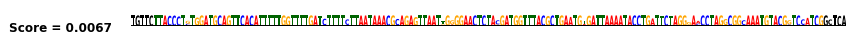

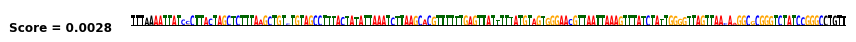

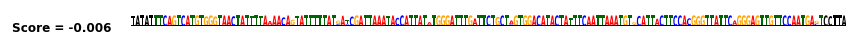

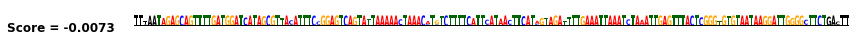

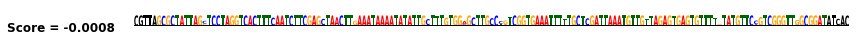

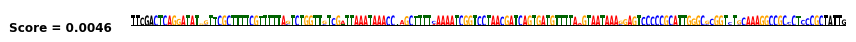

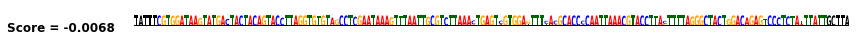

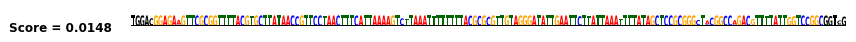

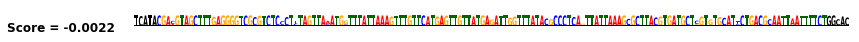

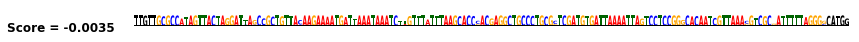

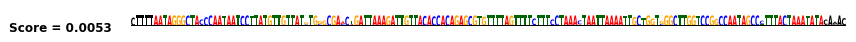

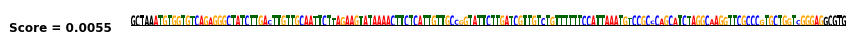

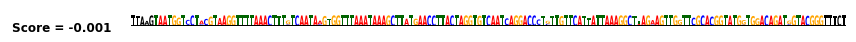

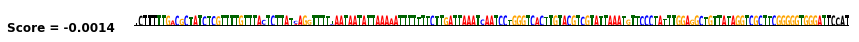

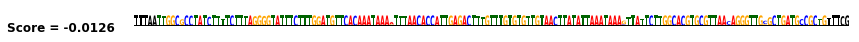

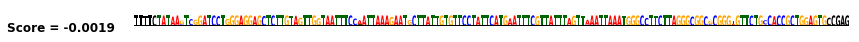

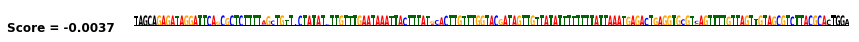

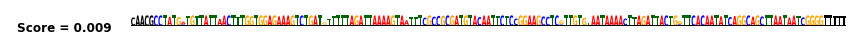

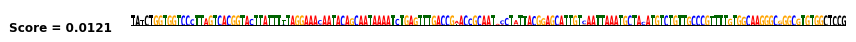

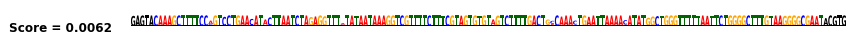

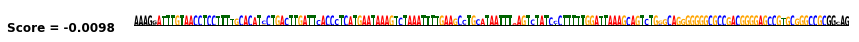

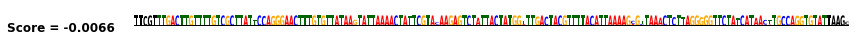

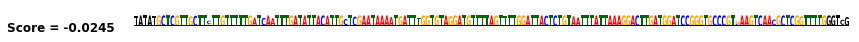

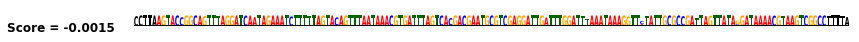

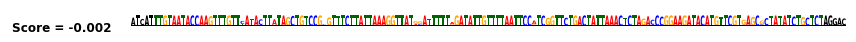

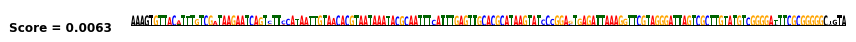

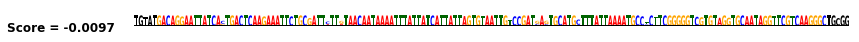

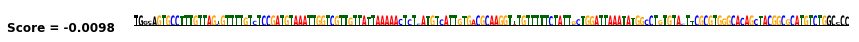

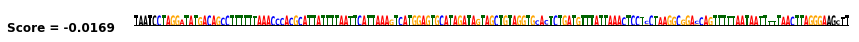

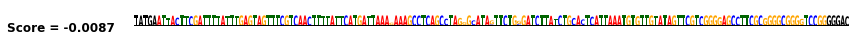

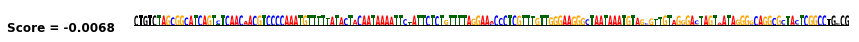

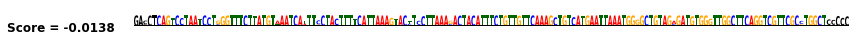

In [24]:
#Visualize a few fake and real sequence patterns

fake_scores = []
fake_pwms = []
fake_sequences = []

for test_index in range(10) :
    class_batch = np.zeros((batch_size, 1), dtype=np.int)
    seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))

    _, fake_pwm_batch, fake_sequence_batch = generator_model.predict_on_batch([class_batch, seed_batch])
    fake_score_batch = discriminator_model.predict_on_batch([fake_sequence_batch])

    fake_scores.append(fake_score_batch)
    fake_pwms.append(fake_pwm_batch)
    fake_sequences.append(fake_sequence_batch)

fake_scores = np.concatenate(fake_scores, axis=0)
fake_pwms = np.concatenate(fake_pwms, axis=0)
fake_sequences = np.concatenate(fake_sequences, axis=0)


print("- Fake Sequences (Randomly Generated) -")

for plot_i in range(32) :
    plot_gan_logo(fake_pwms[plot_i, 0, :, :], fake_scores[plot_i, 0], sequence_template=sequence_templates[0], figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=125-50, plot_end=125-50+157)


In [64]:

for layer_ix, layer in enumerate(generator_model.layers) :
    layer_name = layer.name
    
    if 'batch_norm' not in layer_name :
        new_generator_model.layers[layer_ix].set_weights(layer.get_weights())
    else :
        beta, gamma = layer.get_weights()
        
        new_generator_model.get_layer(layer_name).set_weights([beta, gamma, np.zeros(beta.shape), np.ones(gamma.shape)])


- Fake Sequences (Randomly Generated) -


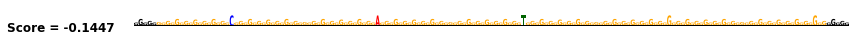

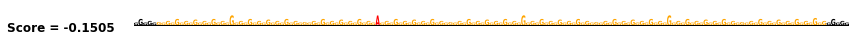

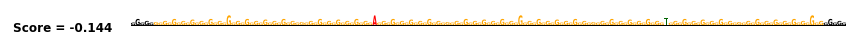

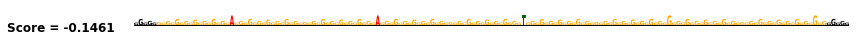

KeyboardInterrupt: 

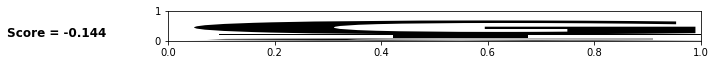

In [46]:
#Visualize a few fake and real sequence patterns

fake_scores = []
fake_pwms = []
fake_sequences = []

for test_index in range(10) :
    class_batch = np.zeros((batch_size, 1), dtype=np.int)
    seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))

    _, fake_pwm_batch, fake_sequence_batch = new_generator_model.predict_on_batch([class_batch, seed_batch])
    fake_score_batch = discriminator_model.predict_on_batch([fake_sequence_batch])

    fake_scores.append(fake_score_batch)
    fake_pwms.append(fake_pwm_batch)
    fake_sequences.append(fake_sequence_batch)

fake_scores = np.concatenate(fake_scores, axis=0)
fake_pwms = np.concatenate(fake_pwms, axis=0)
fake_sequences = np.concatenate(fake_sequences, axis=0)


print("- Fake Sequences (Randomly Generated) -")

for plot_i in range(32) :
    plot_gan_logo(fake_pwms[plot_i, 0, :, :], fake_scores[plot_i, 0], sequence_template=sequence_templates[0], figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=125-50, plot_end=125-50+157)


In [75]:

n_batch_norm_train_iters = 5000

#Generate target labels
dummy_data_target = np.zeros((batch_size,), dtype=np.float32)
dummy_sample_weights = np.zeros((batch_size,), dtype=np.float32)

for train_iter in range(n_batch_norm_train_iters) :
    if train_iter % 1000 == 0 :
        print("Training iteration " + str(train_iter) + "...")
    
    class_batch = np.zeros((batch_size, 1), dtype=np.int)
    seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))
    
    _, _, _, _ = new_generator_model.train_on_batch(
        [class_batch, seed_batch],
        [dummy_data_target, dummy_data_target, dummy_data_target]
    )


Training iteration 0...
Training iteration 1000...
Training iteration 2000...
Training iteration 3000...
Training iteration 4000...


In [76]:

trained_batch_norm_generator_model = new_generator_model


In [77]:

bn_0_weights = trained_batch_norm_generator_model.get_layer('policy_generator_resblock_0_0_batch_norm_0').get_weights()

print(len(bn_0_weights))


4


In [78]:
bn_0_weights

[array([1.0096854 , 0.98420805, 1.0028489 , 1.0258093 , 1.007991  ,
        0.9939886 , 0.99522495, 1.0152191 , 0.97233677, 1.0239626 ,
        0.98858345, 1.0160818 , 1.0055826 , 0.95478207, 1.0163786 ,
        0.98090076, 0.99927205, 0.9831271 , 0.96864533, 1.0008507 ,
        0.9857222 , 1.0144293 , 1.0108804 , 0.9880517 , 1.0078658 ,
        0.95680666, 0.986764  , 0.9378343 , 0.9983527 , 0.97312737,
        0.98376715, 0.9964286 , 1.0261722 , 1.0095084 , 0.96439826,
        1.0575829 , 1.0082079 , 0.99544376, 1.0017066 , 1.0107539 ,
        1.0345703 , 0.9919967 , 1.0338243 , 1.0268109 , 1.0314319 ,
        1.0611944 , 1.0228293 , 1.0296695 , 0.9596553 , 1.076379  ,
        1.0427657 , 0.95100623, 1.038019  , 0.9817032 , 1.0317051 ,
        1.0040144 , 1.000399  , 0.9651579 , 1.0358375 , 0.98058236,
        1.0096743 , 1.021484  , 1.0040852 , 0.97782815, 0.9636719 ,
        1.0243679 , 1.0114572 , 0.95846206, 0.9622355 , 0.99509805,
        0.9718952 , 1.0443759 , 0.9929142 , 1.02

- Fake Sequences (Randomly Generated) -


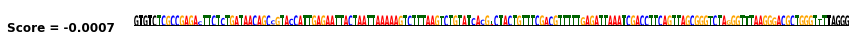

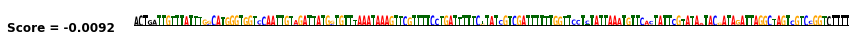

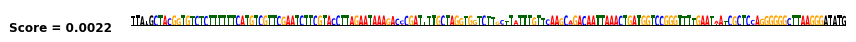

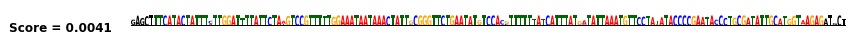

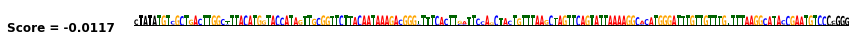

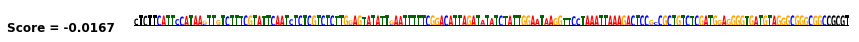

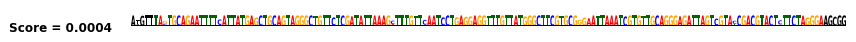

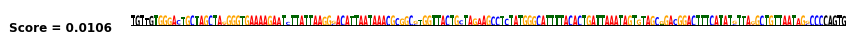

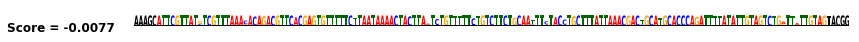

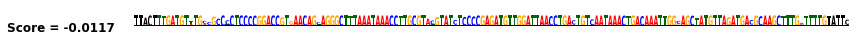

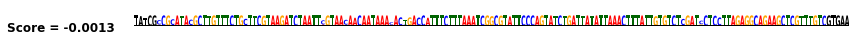

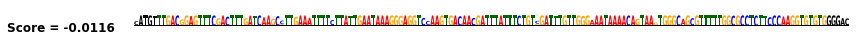

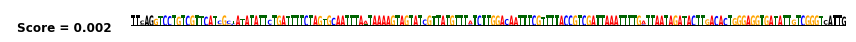

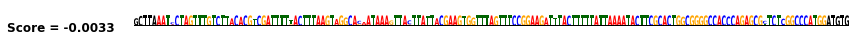

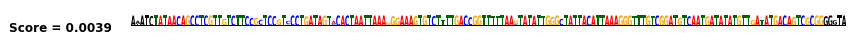

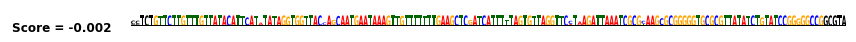

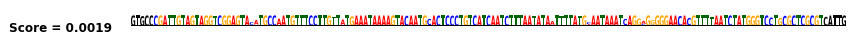

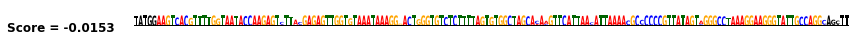

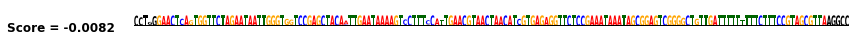

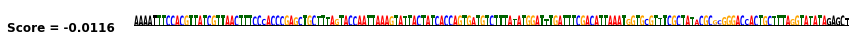

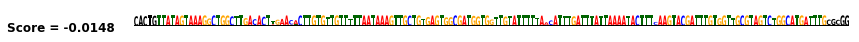

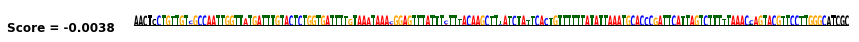

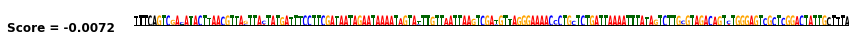

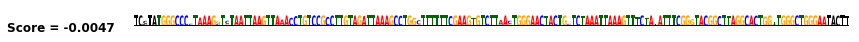

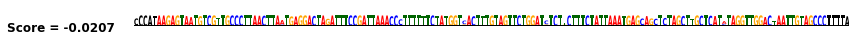

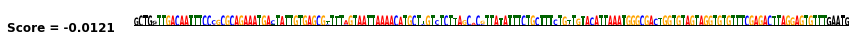

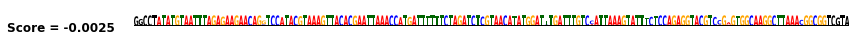

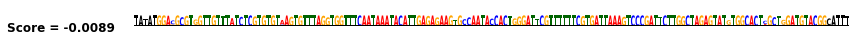

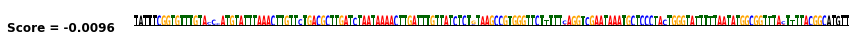

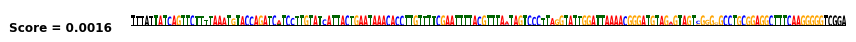

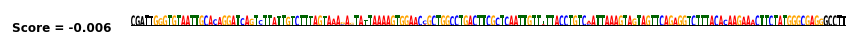

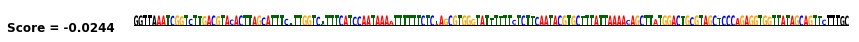

In [79]:
#Visualize a few fake and real sequence patterns

fake_scores = []
fake_pwms = []
fake_sequences = []

for test_index in range(10) :
    class_batch = np.zeros((batch_size, 1), dtype=np.int)
    seed_batch = np.random.uniform(low=-1.0, high=1.0, size=(batch_size, 100))

    _, fake_pwm_batch, fake_sequence_batch = trained_batch_norm_generator_model.predict_on_batch([class_batch, seed_batch])
    fake_score_batch = discriminator_model.predict_on_batch([fake_sequence_batch])

    fake_scores.append(fake_score_batch)
    fake_pwms.append(fake_pwm_batch)
    fake_sequences.append(fake_sequence_batch)

fake_scores = np.concatenate(fake_scores, axis=0)
fake_pwms = np.concatenate(fake_pwms, axis=0)
fake_sequences = np.concatenate(fake_sequences, axis=0)


print("- Fake Sequences (Randomly Generated) -")

for plot_i in range(32) :
    plot_gan_logo(fake_pwms[plot_i, 0, :, :], fake_scores[plot_i, 0], sequence_template=sequence_templates[0], figsize=(12, 0.55), width_ratios=[1, 7], logo_height=1.0, plot_start=125-50, plot_end=125-50+157)


In [80]:
#Save model weights and evaluation metrics
save_dir = 'saved_models'

task_suffix = '_simple'

gen_suffix = '_gen_new_resnet'
disc_suffix = '_disc_new_resnet'

train_suffix = '_sngan_multisample_batchnorm_w_inference_params'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_name = 'gan' + task_suffix + gen_suffix + disc_suffix + train_suffix + '_generator.h5'
model_path = os.path.join(save_dir, model_name)
trained_batch_norm_generator_model.save(model_path)
print('Saved trained model at %s ' % model_path)


Saved trained model at saved_models/gan_simple_gen_new_resnet_disc_new_resnet_sngan_multisample_batchnorm_w_inference_params_generator.h5 
